# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains trade studies performed with the VGG16 model pre-trained with ImageNet weights. All of the following runs use a subset of the data (linked above), ~20,0000 data points.

All models contain:
- VGG16 as the base model
- VGG16's preprocess_input applied in the ImageDataGenerator 
- preprocess_input: converts images from RGB to BGR, and zero-centers it with respects to ImageNet dataset, without scaling
- Data augmentation (e.g. randomized flipping, rotation, etc.)
- No rescaling factor is used


Differences in the models are as follows:
1. Binary cross-entropy loss + block 1 - 3 frozen
2. Binary cross-entropy loss + no blocks frozen
3. Binary cross-entropy loss + sample weights from sklearn + block 1 - 3 frozen
4. Weighted loss + block 1 - 3 frozen
5. Weighted loss + block 1 - 3 frozen + no normalization on class_weights
6. Weighted loss + no blocks frozen
7. Weighted loss + stratified sampling + block 1 - 3 frozen
8. Weighted loss + stratified sampling + no blocks frozen
9. Weighted loss + block 1 - 3 frozen + GlobalAveragePooling
10. Weighted loss + stratified sampling + block 1 - 3 frozen + GlobalAveragePooling



##### IMPORTANT NOTE: Rerunning this notebook may result in different results due to the seed option not being set in the flow_from_dataframe function. This oversight is corrected in round 2 of tuning.

## Imports
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [3]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

## Data Preprocessing
---

### Wrangling

In [4]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

### Sampling

In [7]:
plt.style.use('tableau-colorblind10')

In [8]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

In [9]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

# Normalized class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 
    
# Non-normalized class weights for weighted loss
pos_2 = np.array([])
neg_2 = np.array([])
for d in weights:
    pos_2 = np.append(pos_2, d[1])
    neg_2 = np.append(neg_2, d[0])

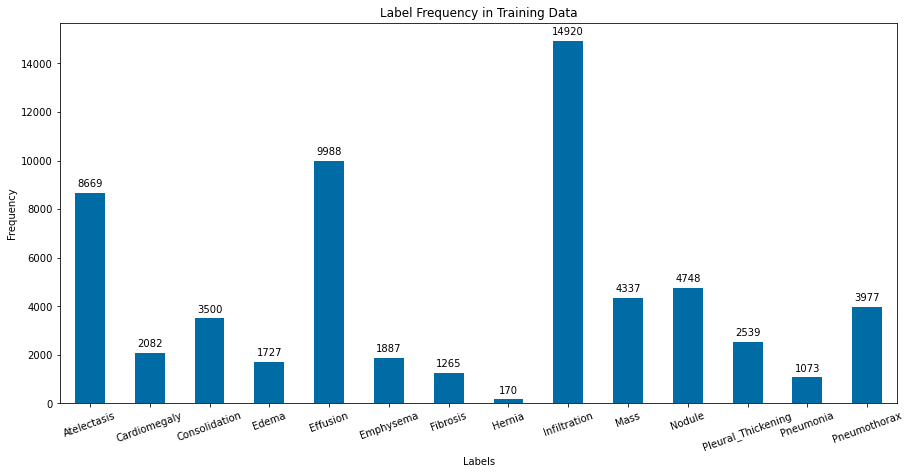

In [10]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

Atelectasis           5171.0
Cardiomegaly          1692.0
Consolidation         2795.0
Edema                 1501.0
Effusion              6399.0
Emphysema             1581.0
Fibrosis              1108.0
Hernia                 170.0
Infiltration          6912.0
Mass                  3070.0
Nodule                3101.0
Pleural_Thickening    2049.0
Pneumonia             1020.0
Pneumothorax          2759.0
dtype: float32

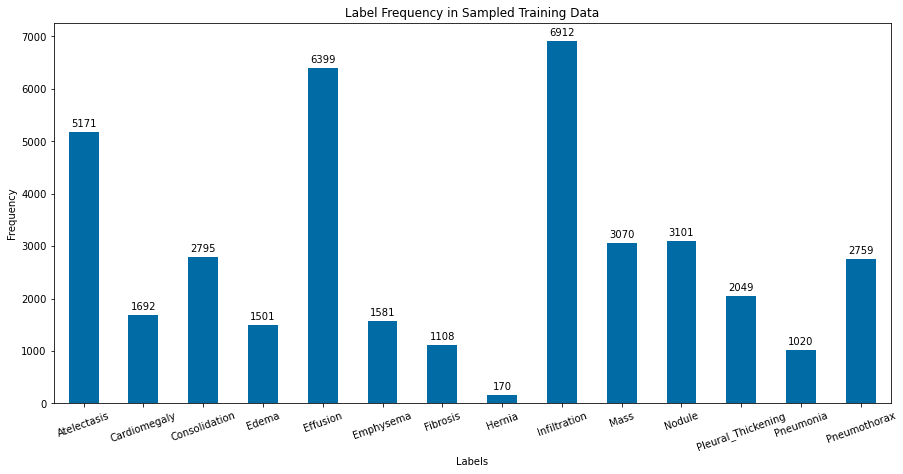

In [11]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

Atelectasis           4531.0
Cardiomegaly          2113.0
Consolidation         2805.0
Edema                 2301.0
Effusion              5653.0
Emphysema             2182.0
Fibrosis              1850.0
Hernia                1528.0
Infiltration          6503.0
Mass                  3197.0
Nodule                2896.0
Pleural_Thickening    2544.0
Pneumonia             1970.0
Pneumothorax          2858.0
dtype: float32

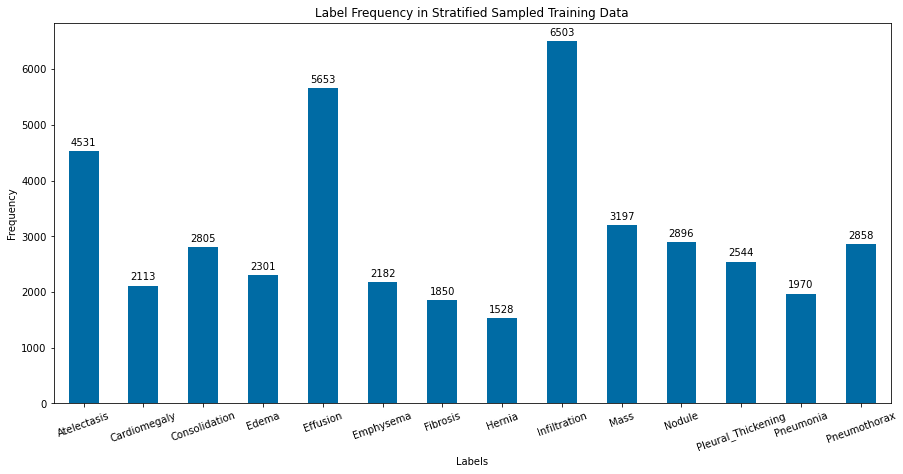

In [54]:
stratified_sampled_train_df = pd.DataFrame([])

n = 1500

# Sample each label
for lbl in labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])
    
# Sample null label
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
stratified_sampled_train_df = pd.concat([stratified_sampled_train_df, temp])

plot_df_freq(stratified_sampled_train_df, labels, offset=100, title='Label Frequency in Stratified Sampled Training Data')

In [13]:
def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

### Helper Functions

In [14]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, color_mode='rgb', 
                    weight_col=None, sample_norm=False, rescale_factor=None):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_norm,
        samplewise_std_normalization=sample_norm,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation'
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols
    )
    
    return train_generator, validation_generator, test_generator

In [16]:
# Base Models
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)

# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

2022-01-24 06:42:24.496779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-24 06:42:24.496935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


## VGG16 Trade Studies
---

In [17]:
%%html
<style>
table {float:left}
</style>

### Model 1
Baseline Model

|Parameter|Notes|
|:---|:---|
|Loss | Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | train_df |

In [18]:
train_generator_1, valid_generator_1, test_generator_1 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [19]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [20]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [21]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-1.h5'

chkpt_1 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [22]:
%%time
history_1 = model.fit(
    train_generator_1, 
    validation_data=valid_generator_1,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_1, early, reduce_lr]
)

2022-01-22 14:00:33.429910: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-22 14:00:33.610245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 0.4319

2022-01-22 14:04:53.393893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.52185, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-1.h5
250/250 [==============================] - 324s 1s/step - loss: 0.4319 - val_loss: 0.5219 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.3301
Epoch 00002: val_loss did not improve from 0.52185
250/250 [==============================] - 324s 1s/step - loss: 0.3301 - val_loss: 0.5405 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.3275
Epoch 00003: val_loss improved from 0.52185 to 0.50924, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-1.h5
250/250 [==============================] - 325s 1s/step - loss: 0.3275 - val_loss: 0.5092 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.3440
Epoch 00004: val_loss did not improve from 0.50924
250/250 [==============================] - 325s 1

In [23]:
y_pred_1 = model.predict(test_generator_1, batch_size=64, verbose=True)

2022-01-22 15:00:07.485268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 448s 1s/step


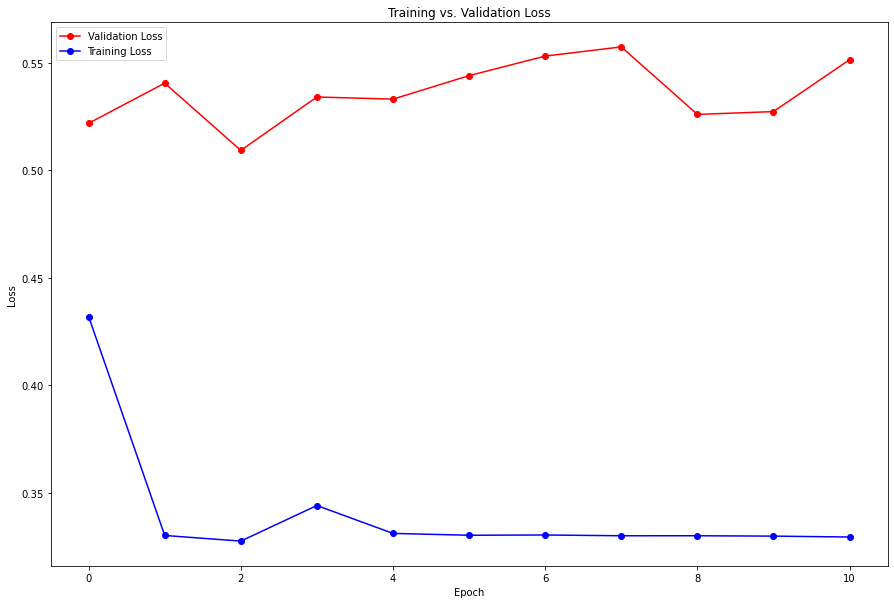

In [24]:
plot_losses(history_1)

AUC = 0.5480 for Atelectasis
AUC = 0.5553 for Cardiomegaly
AUC = 0.5974 for Consolidation
AUC = 0.6565 for Edema
AUC = 0.5623 for Effusion
AUC = 0.5160 for Emphysema
AUC = 0.4244 for Fibrosis
AUC = 0.5321 for Hernia
AUC = 0.5732 for Infiltration
AUC = 0.4904 for Mass
AUC = 0.4619 for Nodule
AUC = 0.4789 for Pleural_Thickening
AUC = 0.5581 for Pneumonia
AUC = 0.5180 for Pneumothorax


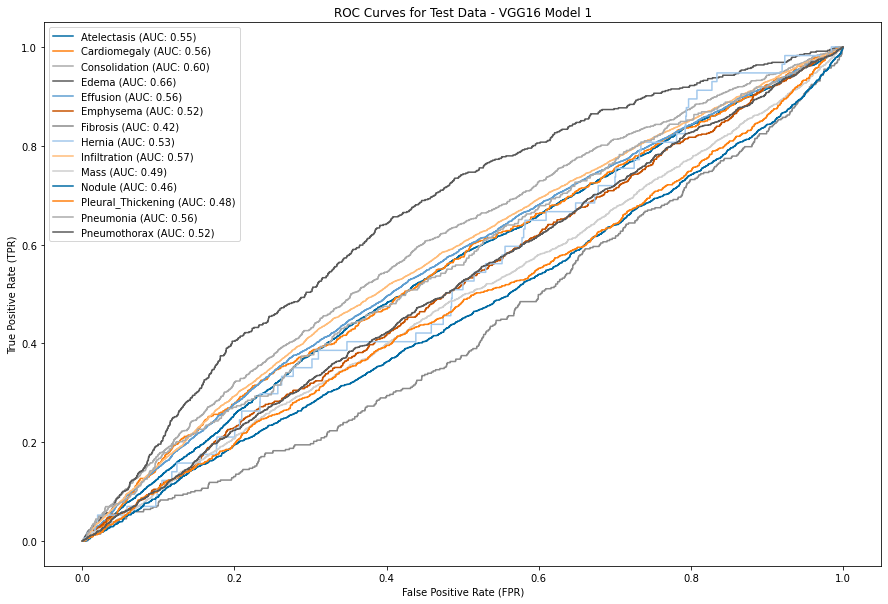

In [25]:
plot_roc_auc(y_pred_1, test_df, labels, model_name='VGG16 Model 1')

AUC = 0.1183 for Atelectasis
AUC = 0.0300 for Cardiomegaly
AUC = 0.0589 for Consolidation
AUC = 0.0340 for Edema
AUC = 0.1446 for Effusion
AUC = 0.0237 for Emphysema
AUC = 0.0124 for Fibrosis
AUC = 0.0023 for Hernia
AUC = 0.2184 for Infiltration
AUC = 0.0514 for Mass
AUC = 0.0520 for Nodule
AUC = 0.0291 for Pleural_Thickening
AUC = 0.0162 for Pneumonia
AUC = 0.0495 for Pneumothorax


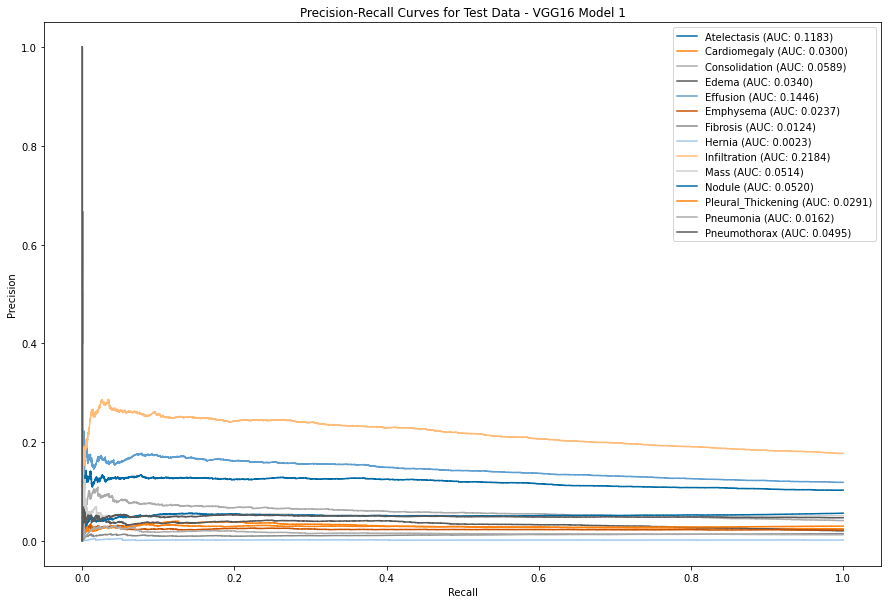

In [26]:
plot_precision_recall_auc(y_pred_1, test_df, labels, model_name='VGG16 Model 1')

### Model 2

|Parameter|Notes|
|:---|:---|
|Loss | Binary Cross-Entropy |
|Blocks Frozen | None|
|Dataset | train_df |

In [27]:
train_generator_2, valid_generator_2, test_generator_2 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [28]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [29]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [30]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-2.h5'

chkpt_2 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [31]:
%%time
history_2 = model.fit(
    train_generator_2, 
    validation_data=valid_generator_2,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_2, early, reduce_lr]
)

Epoch 1/40


2022-01-22 15:07:37.972946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.3415

2022-01-22 15:13:45.391224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.52813, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-2.h5
250/250 [==============================] - 432s 2s/step - loss: 0.3415 - val_loss: 0.5281 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.3221
Epoch 00002: val_loss did not improve from 0.52813
250/250 [==============================] - 430s 2s/step - loss: 0.3221 - val_loss: 0.5412 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.3207
Epoch 00003: val_loss improved from 0.52813 to 0.51601, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-2.h5
250/250 [==============================] - 430s 2s/step - loss: 0.3207 - val_loss: 0.5160 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.3186
Epoch 00004: val_loss improved from 0.51601 to 0.51396, saving model to /Users/tungnguyen/Documents/

In [32]:
y_pred_2 = model.predict(test_generator_2, batch_size=64, verbose=True)

2022-01-22 17:45:23.811229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 458s 1s/step


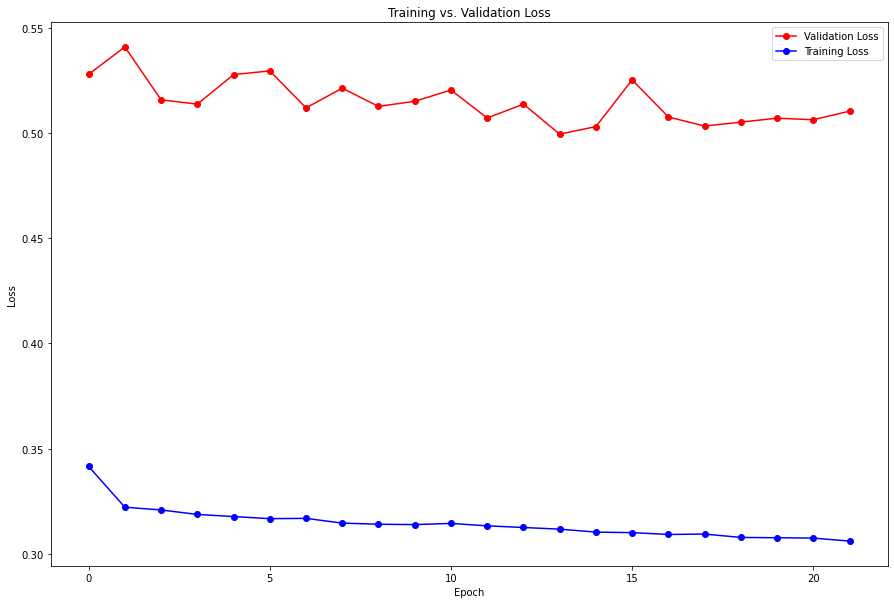

In [33]:
plot_losses(history_2)

AUC = 0.7125 for Atelectasis
AUC = 0.8087 for Cardiomegaly
AUC = 0.7172 for Consolidation
AUC = 0.8237 for Edema
AUC = 0.7958 for Effusion
AUC = 0.5886 for Emphysema
AUC = 0.6545 for Fibrosis
AUC = 0.6709 for Hernia
AUC = 0.6452 for Infiltration
AUC = 0.5479 for Mass
AUC = 0.5562 for Nodule
AUC = 0.5966 for Pleural_Thickening
AUC = 0.4819 for Pneumonia
AUC = 0.6349 for Pneumothorax


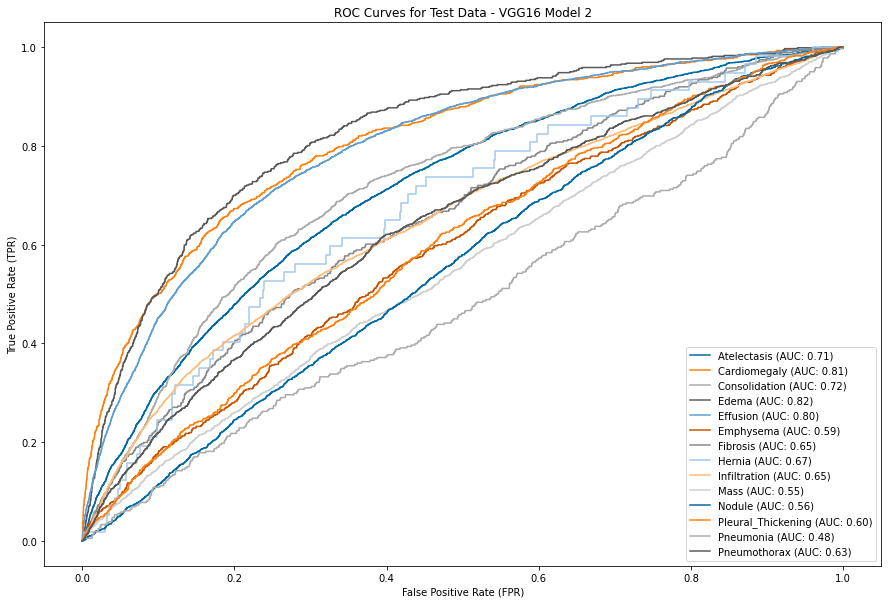

In [34]:
plot_roc_auc(y_pred_2, test_df, labels, model_name='VGG16 Model 2')

AUC = 0.2206 for Atelectasis
AUC = 0.1683 for Cardiomegaly
AUC = 0.0930 for Consolidation
AUC = 0.0954 for Edema
AUC = 0.3645 for Effusion
AUC = 0.0322 for Emphysema
AUC = 0.0284 for Fibrosis
AUC = 0.0037 for Hernia
AUC = 0.2905 for Infiltration
AUC = 0.0639 for Mass
AUC = 0.0638 for Nodule
AUC = 0.0435 for Pleural_Thickening
AUC = 0.0129 for Pneumonia
AUC = 0.0783 for Pneumothorax


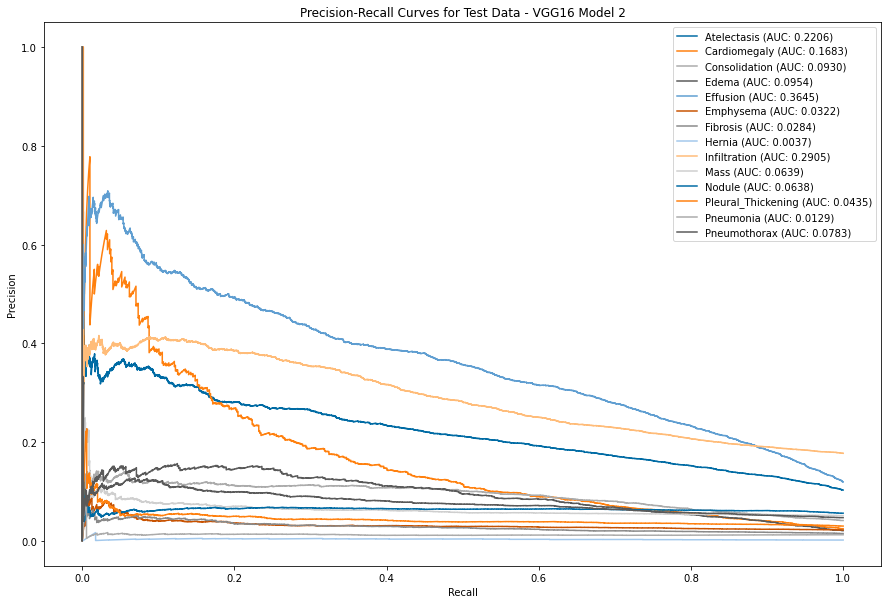

In [35]:
plot_precision_recall_auc(y_pred_2, test_df, labels, model_name='VGG16 Model 2')

### Model 3
Baseline Model + sample weights from sklearn

|Parameter|Notes|
|:---|:---|
|Loss | Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | train_df |

In [36]:
train_generator_3, valid_generator_3, test_generator_3 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col='sample_weights', sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [37]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [38]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)

In [39]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-3.h5'

chkpt_3 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [40]:
%%time
history_3 = model.fit(
    train_generator_3, 
    validation_data=valid_generator_3,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_3, early, reduce_lr]
)

Epoch 1/40


2022-01-22 17:53:04.601292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.0176

2022-01-22 17:57:24.546548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.48659, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-3.h5
250/250 [==============================] - 325s 1s/step - loss: 0.0176 - val_loss: 0.4866 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.0172
Epoch 00002: val_loss improved from 0.48659 to 0.47242, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-3.h5
250/250 [==============================] - 324s 1s/step - loss: 0.0172 - val_loss: 0.4724 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.0170
Epoch 00003: val_loss improved from 0.47242 to 0.46766, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-3.h5
250/250 [==============================] - 324s 1s/step - loss: 0.0170 - val_loss: 0.4677 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.

In [41]:
y_pred_3 = model.predict(test_generator_3, batch_size=64, verbose=True)

2022-01-22 19:08:50.716044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 447s 1s/step


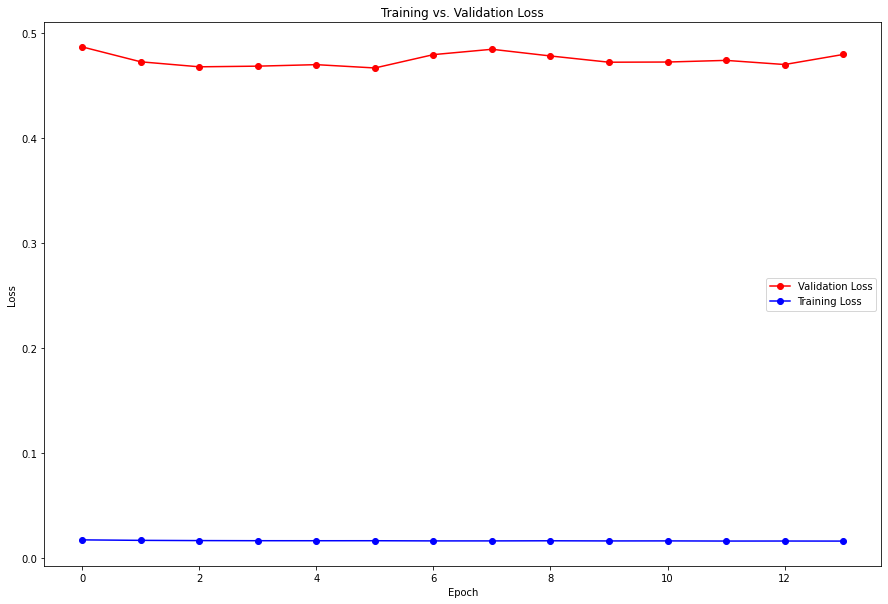

In [42]:
plot_losses(history_3)

AUC = 0.6677 for Atelectasis
AUC = 0.7595 for Cardiomegaly
AUC = 0.6918 for Consolidation
AUC = 0.7881 for Edema
AUC = 0.7802 for Effusion
AUC = 0.5666 for Emphysema
AUC = 0.6002 for Fibrosis
AUC = 0.7089 for Hernia
AUC = 0.6344 for Infiltration
AUC = 0.5424 for Mass
AUC = 0.5332 for Nodule
AUC = 0.5177 for Pleural_Thickening
AUC = 0.5036 for Pneumonia
AUC = 0.6025 for Pneumothorax


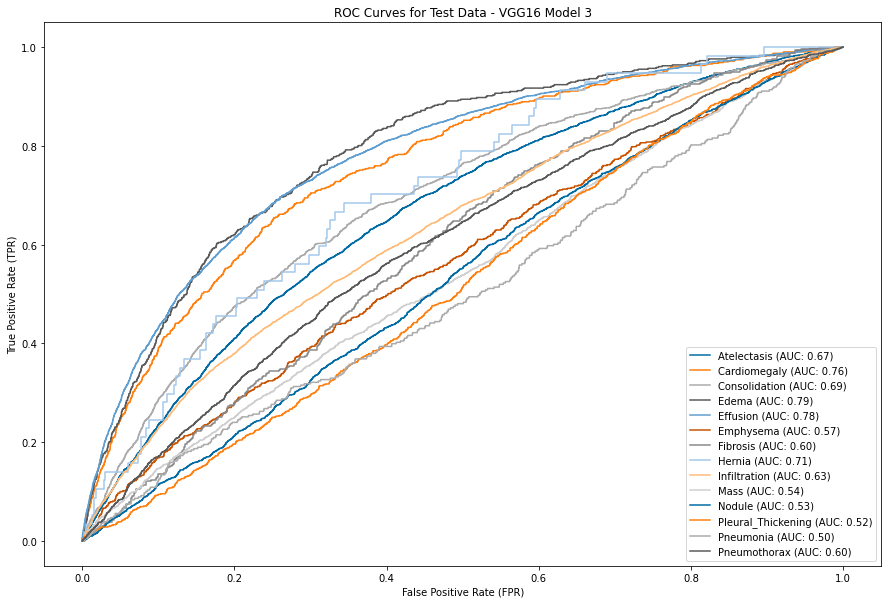

In [43]:
plot_roc_auc(y_pred_3, test_df, labels, model_name='VGG16 Model 3')

AUC = 0.1771 for Atelectasis
AUC = 0.0858 for Cardiomegaly
AUC = 0.0875 for Consolidation
AUC = 0.0816 for Edema
AUC = 0.3489 for Effusion
AUC = 0.0294 for Emphysema
AUC = 0.0193 for Fibrosis
AUC = 0.0048 for Hernia
AUC = 0.2727 for Infiltration
AUC = 0.0624 for Mass
AUC = 0.0602 for Nodule
AUC = 0.0314 for Pleural_Thickening
AUC = 0.0135 for Pneumonia
AUC = 0.0667 for Pneumothorax


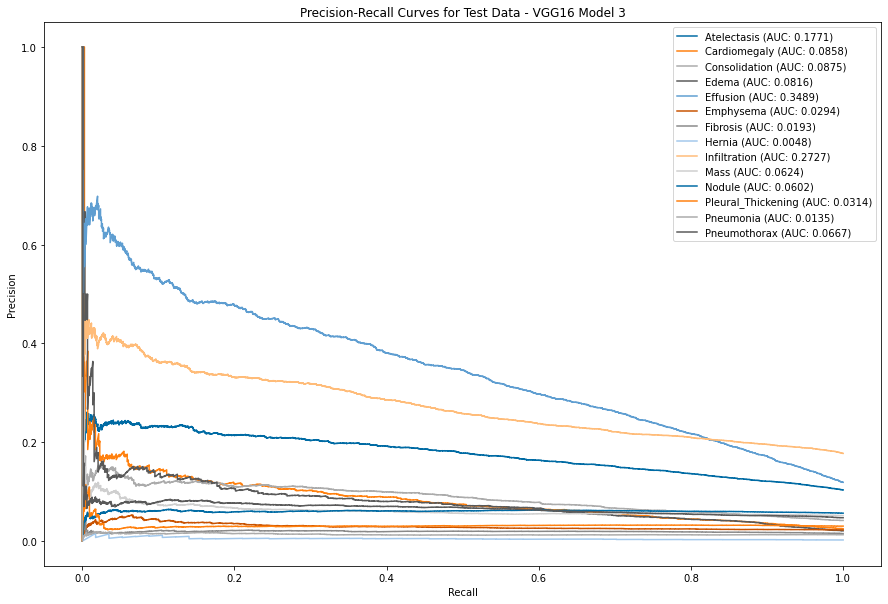

In [44]:
plot_precision_recall_auc(y_pred_3, test_df, labels, model_name='VGG16 Model 3')

### Model 4
Baseline Weighted Loss Model. Loss is weighted more heavily toward +ve occurrences.

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | train_df |

In [45]:
train_generator_4, valid_generator_4, test_generator_4 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [46]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [47]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [48]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-4.h5'

chkpt_4 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [49]:
%%time
history_4 = model.fit(
    train_generator_4, 
    validation_data=valid_generator_4,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_4, early, reduce_lr]
)

Epoch 1/40


2022-01-22 19:16:20.019419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1763

2022-01-22 19:20:40.414895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.46973, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-4.h5
250/250 [==============================] - 325s 1s/step - loss: 1.1763 - val_loss: 1.4697 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1414
Epoch 00002: val_loss improved from 1.46973 to 1.45844, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-4.h5
250/250 [==============================] - 322s 1s/step - loss: 1.1414 - val_loss: 1.4584 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1362
Epoch 00003: val_loss did not improve from 1.45844
250/250 [==============================] - 322s 1s/step - loss: 1.1362 - val_loss: 1.5539 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1304
Epoch 00004: val_loss did not improve from 1.45844
250/250 [==============================] - 322s 1

In [50]:
y_pred_4 = model.predict(test_generator_4, batch_size=64, verbose=True)

2022-01-22 20:10:05.670216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 445s 1s/step


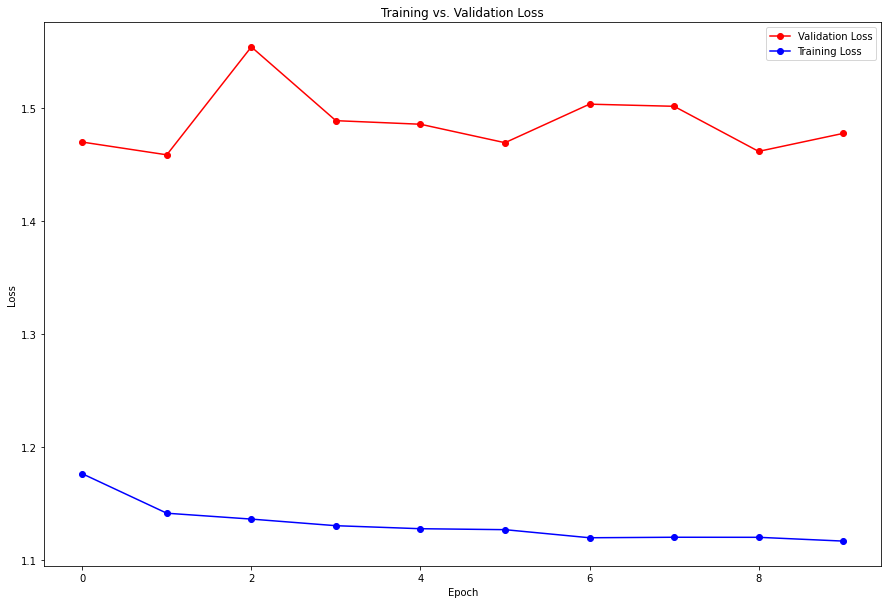

In [51]:
plot_losses(history_4)

AUC = 0.7308 for Atelectasis
AUC = 0.8346 for Cardiomegaly
AUC = 0.7268 for Consolidation
AUC = 0.8426 for Edema
AUC = 0.8018 for Effusion
AUC = 0.6477 for Emphysema
AUC = 0.6515 for Fibrosis
AUC = 0.7453 for Hernia
AUC = 0.6600 for Infiltration
AUC = 0.5804 for Mass
AUC = 0.5635 for Nodule
AUC = 0.6075 for Pleural_Thickening
AUC = 0.4967 for Pneumonia
AUC = 0.6604 for Pneumothorax


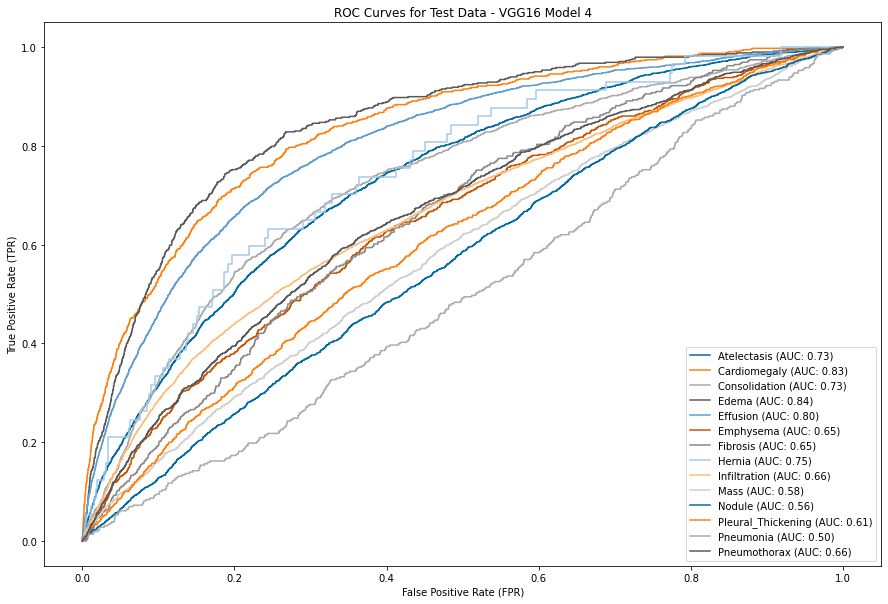

In [52]:
plot_roc_auc(y_pred_4, test_df, labels, model_name='VGG16 Model 4')

AUC = 0.2390 for Atelectasis
AUC = 0.1671 for Cardiomegaly
AUC = 0.1023 for Consolidation
AUC = 0.1118 for Edema
AUC = 0.3752 for Effusion
AUC = 0.0395 for Emphysema
AUC = 0.0243 for Fibrosis
AUC = 0.0063 for Hernia
AUC = 0.3035 for Infiltration
AUC = 0.0720 for Mass
AUC = 0.0669 for Nodule
AUC = 0.0433 for Pleural_Thickening
AUC = 0.0126 for Pneumonia
AUC = 0.0852 for Pneumothorax


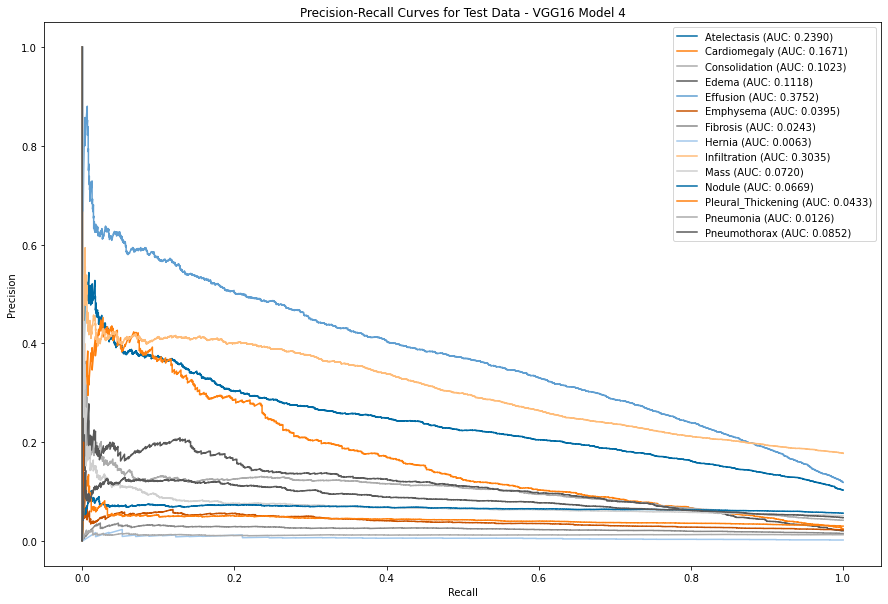

In [53]:
plot_precision_recall_auc(y_pred_4, test_df, labels, model_name='VGG16 Model 4')

### Model 5
Same as Model 4 except with no normalization on the class weights passed to the loss function.

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | train_df |

In [54]:
train_generator_5, valid_generator_5, test_generator_5 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [55]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [56]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos_2, neg_2)
)

In [57]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-5.h5'

chkpt_5 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [58]:
%%time
history_5 = model.fit(
    train_generator_5, 
    validation_data=valid_generator_5,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_5, early, reduce_lr]
)

Epoch 1/40


2022-01-22 20:17:33.405989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 13.2765

2022-01-22 20:21:54.753087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 24.82912, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-5.h5
250/250 [==============================] - 326s 1s/step - loss: 13.2765 - val_loss: 24.8291 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 12.9223
Epoch 00002: val_loss improved from 24.82912 to 19.78962, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-5.h5
250/250 [==============================] - 323s 1s/step - loss: 12.9223 - val_loss: 19.7896 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 12.7659
Epoch 00003: val_loss did not improve from 19.78962
250/250 [==============================] - 323s 1s/step - loss: 12.7659 - val_loss: 23.0210 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 12.6553
Epoch 00004: val_loss did not improve from 19.78962
250/250 [==========================

In [59]:
y_pred_5 = model.predict(test_generator_5, batch_size=64, verbose=True)

2022-01-22 21:11:26.436798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 445s 1s/step


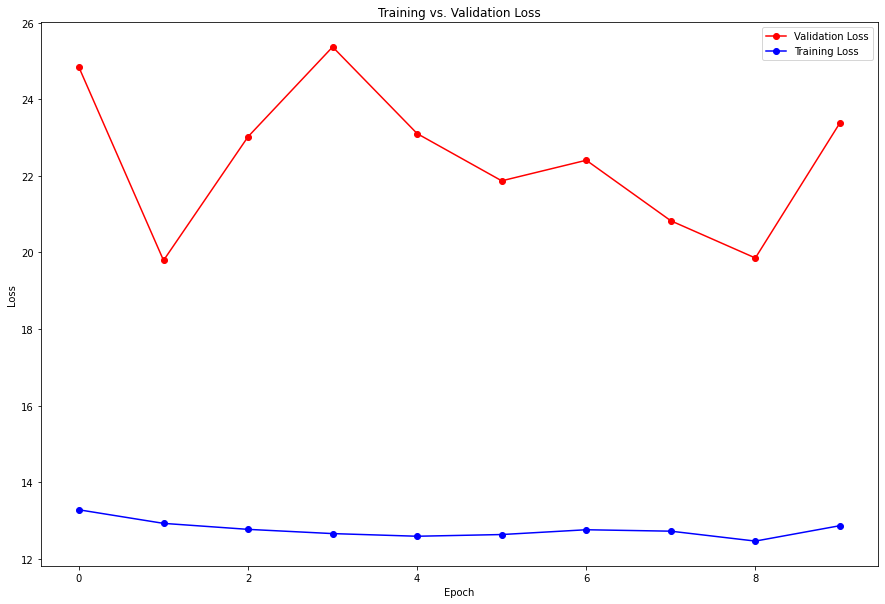

In [60]:
plot_losses(history_5)

AUC = 0.6785 for Atelectasis
AUC = 0.8035 for Cardiomegaly
AUC = 0.7133 for Consolidation
AUC = 0.8329 for Edema
AUC = 0.7783 for Effusion
AUC = 0.5796 for Emphysema
AUC = 0.6189 for Fibrosis
AUC = 0.6953 for Hernia
AUC = 0.6266 for Infiltration
AUC = 0.5223 for Mass
AUC = 0.5404 for Nodule
AUC = 0.5674 for Pleural_Thickening
AUC = 0.4636 for Pneumonia
AUC = 0.6253 for Pneumothorax


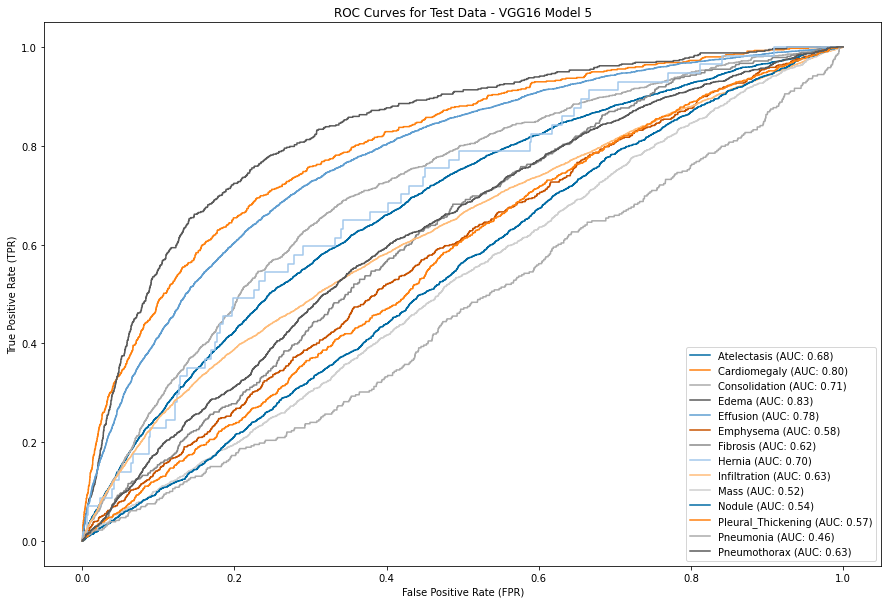

In [61]:
plot_roc_auc(y_pred_5, test_df, labels, model_name='VGG16 Model 5')

AUC = 0.1904 for Atelectasis
AUC = 0.1359 for Cardiomegaly
AUC = 0.0904 for Consolidation
AUC = 0.1019 for Edema
AUC = 0.3412 for Effusion
AUC = 0.0296 for Emphysema
AUC = 0.0210 for Fibrosis
AUC = 0.0046 for Hernia
AUC = 0.2784 for Infiltration
AUC = 0.0542 for Mass
AUC = 0.0606 for Nodule
AUC = 0.0360 for Pleural_Thickening
AUC = 0.0122 for Pneumonia
AUC = 0.0689 for Pneumothorax


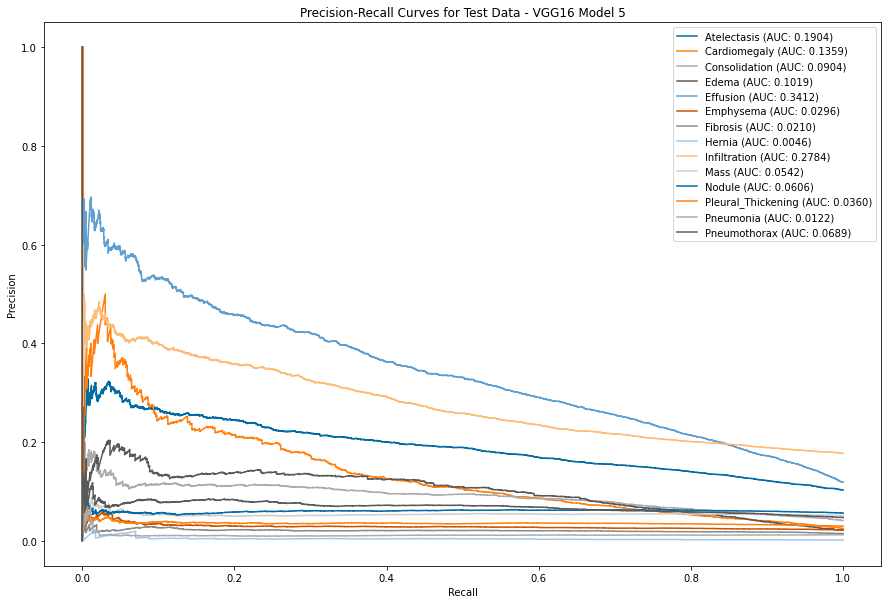

In [62]:
plot_precision_recall_auc(y_pred_5, test_df, labels, model_name='VGG16 Model 5')

### Model 6

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | None |
|Dataset | train_df |

In [63]:
train_generator_6, valid_generator_6, test_generator_6 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [64]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [65]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [66]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-6.h5'

chkpt_6 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [67]:
%%time
history_6 = model.fit(
    train_generator_6, 
    validation_data=valid_generator_6,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_6, early, reduce_lr]
)

Epoch 1/40


2022-01-22 21:18:54.305485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 1.1817

2022-01-22 21:25:00.243262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.50667, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-6.h5
250/250 [==============================] - 430s 2s/step - loss: 1.1817 - val_loss: 1.5067 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.1464
Epoch 00002: val_loss improved from 1.50667 to 1.43333, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-6.h5
250/250 [==============================] - 429s 2s/step - loss: 1.1464 - val_loss: 1.4333 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 1.1414
Epoch 00003: val_loss did not improve from 1.43333
250/250 [==============================] - 429s 2s/step - loss: 1.1414 - val_loss: 1.4898 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 1.1400
Epoch 00004: val_loss did not improve from 1.43333
250/250 [==============================] - 430s 2

In [68]:
y_pred_6 = model.predict(test_generator_6, batch_size=64, verbose=True)

2022-01-22 22:30:23.713930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 447s 1s/step


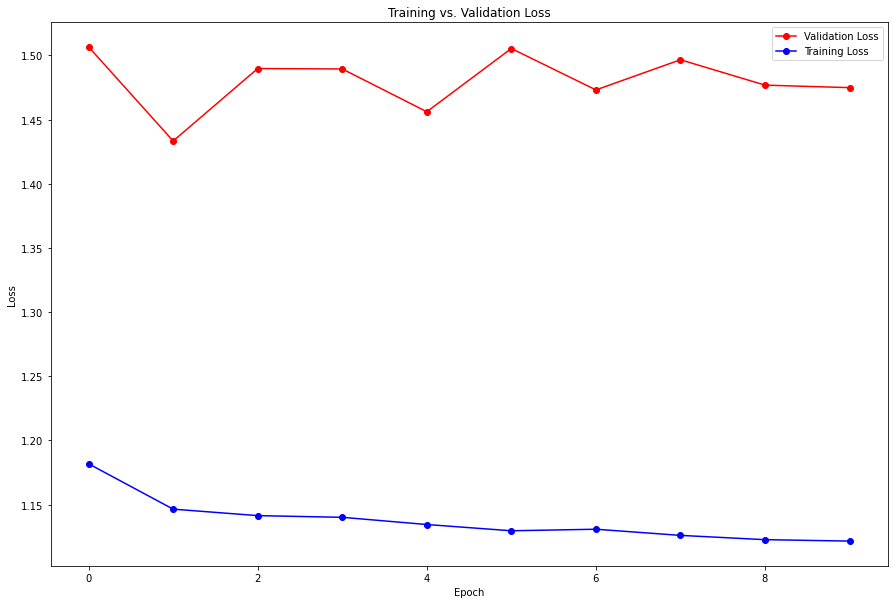

In [69]:
plot_losses(history_6)

AUC = 0.7216 for Atelectasis
AUC = 0.8559 for Cardiomegaly
AUC = 0.7368 for Consolidation
AUC = 0.8440 for Edema
AUC = 0.8058 for Effusion
AUC = 0.6559 for Emphysema
AUC = 0.6431 for Fibrosis
AUC = 0.7167 for Hernia
AUC = 0.6501 for Infiltration
AUC = 0.6100 for Mass
AUC = 0.5601 for Nodule
AUC = 0.6183 for Pleural_Thickening
AUC = 0.5299 for Pneumonia
AUC = 0.6931 for Pneumothorax


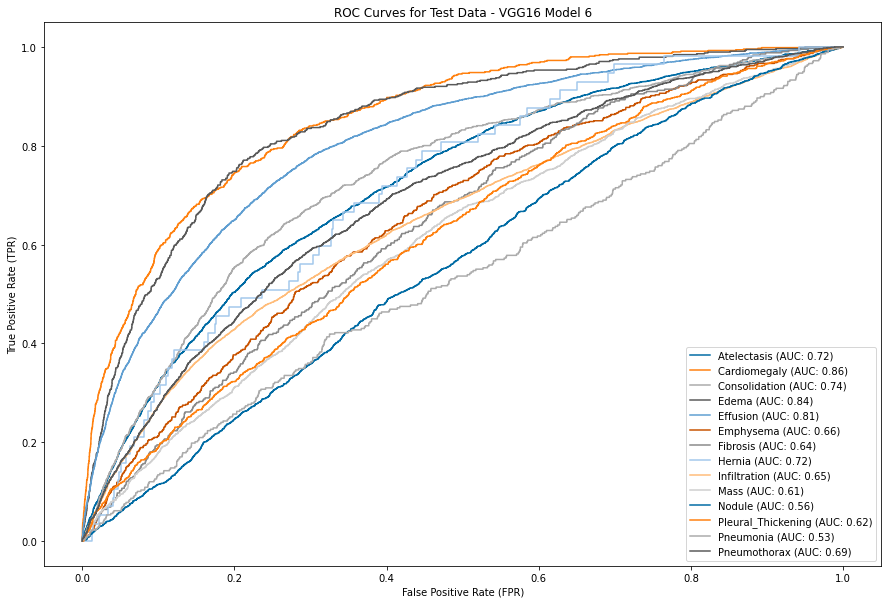

In [70]:
plot_roc_auc(y_pred_6, test_df, labels, model_name='VGG16 Model 6')

AUC = 0.2248 for Atelectasis
AUC = 0.1932 for Cardiomegaly
AUC = 0.1021 for Consolidation
AUC = 0.1164 for Edema
AUC = 0.3879 for Effusion
AUC = 0.0386 for Emphysema
AUC = 0.0240 for Fibrosis
AUC = 0.0043 for Hernia
AUC = 0.2963 for Infiltration
AUC = 0.0758 for Mass
AUC = 0.0649 for Nodule
AUC = 0.0471 for Pleural_Thickening
AUC = 0.0147 for Pneumonia
AUC = 0.1003 for Pneumothorax


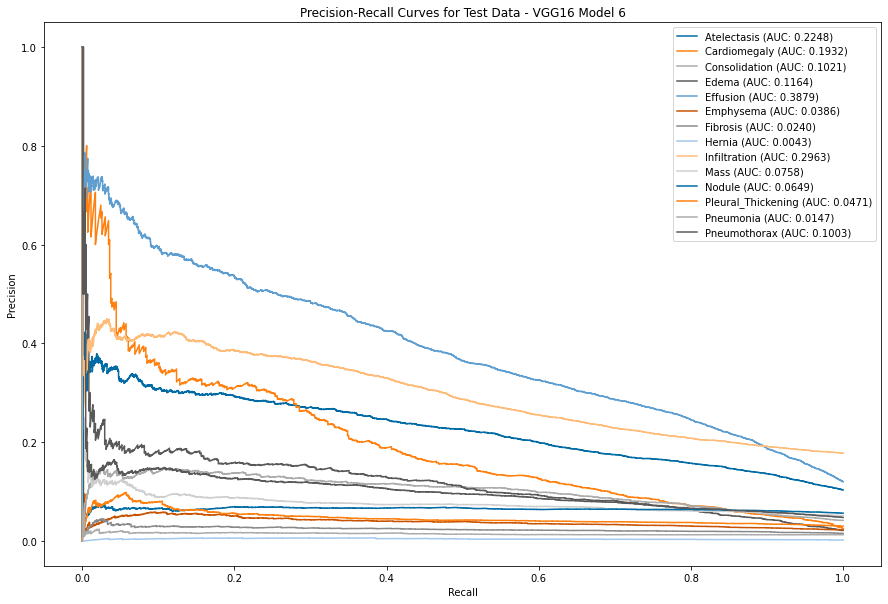

In [71]:
plot_precision_recall_auc(y_pred_6, test_df, labels, model_name='VGG16 Model 6')

### Model 7
Baseline Model for Stratified Sampling

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | stratified_sampled_train_df |

In [55]:
train_generator_7, valid_generator_7, test_generator_7 = datagen_from_df(
    stratified_sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [56]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [57]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [58]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-7.h5'

chkpt_7 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [59]:
%%time
history_7 = model.fit(
    train_generator_7, 
    validation_data=valid_generator_7,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_7, early, reduce_lr]
)

Epoch 1/40


2022-01-24 18:14:36.765735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 17.2526

2022-01-24 18:19:36.398262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 21.01018, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-7.h5
282/282 [==============================] - 373s 1s/step - loss: 17.2526 - val_loss: 21.0102 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 17.2624
Epoch 00002: val_loss did not improve from 21.01018
282/282 [==============================] - 371s 1s/step - loss: 17.2624 - val_loss: 21.0174 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 17.2401
Epoch 00003: val_loss did not improve from 21.01018
282/282 [==============================] - 374s 1s/step - loss: 17.2401 - val_loss: 21.0387 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 17.2256
Epoch 00004: val_loss did not improve from 21.01018
282/282 [==============================] - 376s 1s/step - loss: 17.2256 - val_loss: 21.0166 - lr: 0.0010
Epoch 5/40
282/282 [================

In [60]:
y_pred_7 = model.predict(test_generator_7, batch_size=64, verbose=True)

2022-01-24 20:05:40.023204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 454s 1s/step


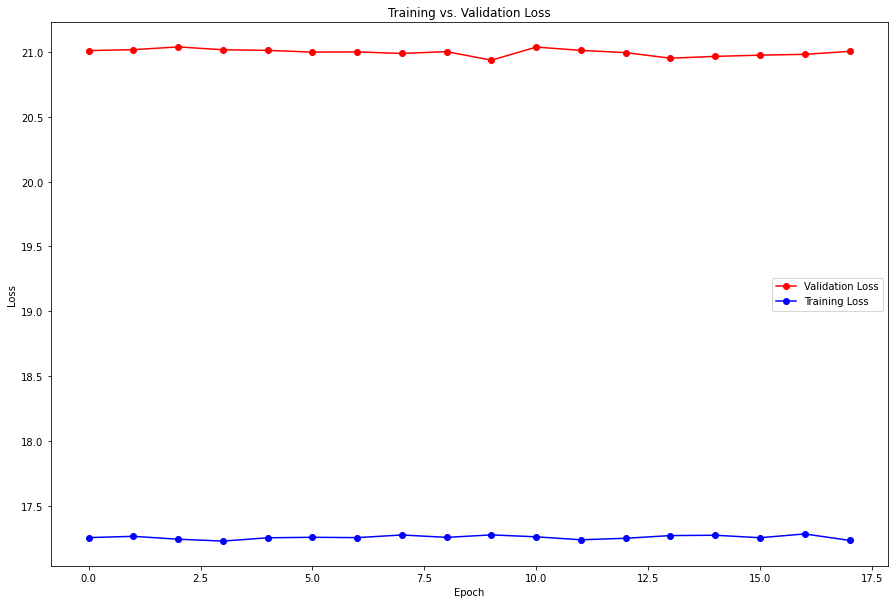

In [61]:
plot_losses(history_7)

AUC = 0.5000 for Atelectasis
AUC = 0.5040 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.5000 for Effusion
AUC = 0.5005 for Emphysema
AUC = 0.5597 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.5000 for Pneumothorax


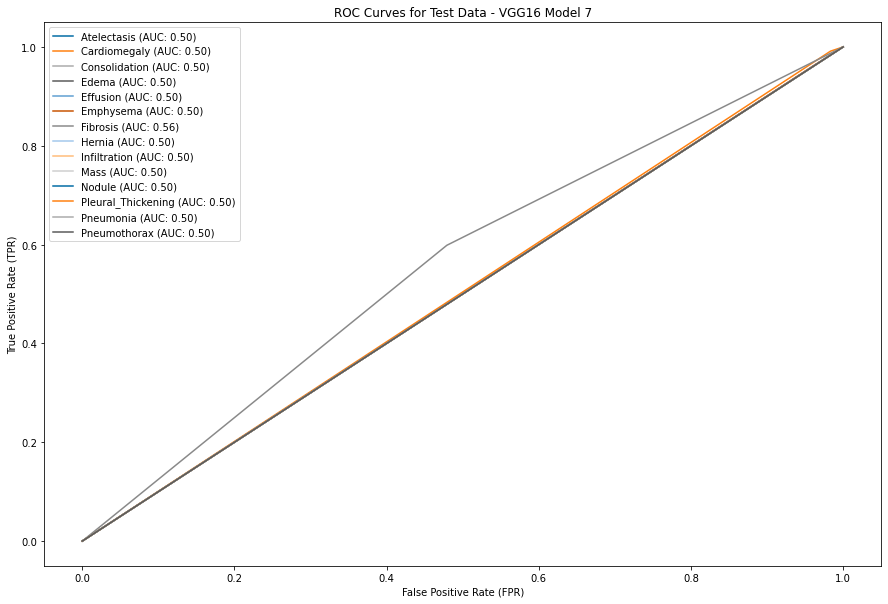

In [62]:
plot_roc_auc(y_pred_7, test_df, labels, model_name='VGG16 Model 7')

AUC = 0.5516 for Atelectasis
AUC = 0.5083 for Cardiomegaly
AUC = 0.5208 for Consolidation
AUC = 0.5103 for Edema
AUC = 0.5594 for Effusion
AUC = 0.4926 for Emphysema
AUC = 0.3116 for Fibrosis
AUC = 0.5010 for Hernia
AUC = 0.5887 for Infiltration
AUC = 0.5258 for Mass
AUC = 0.5282 for Nodule
AUC = 0.5151 for Pleural_Thickening
AUC = 0.5064 for Pneumonia
AUC = 0.0236 for Pneumothorax


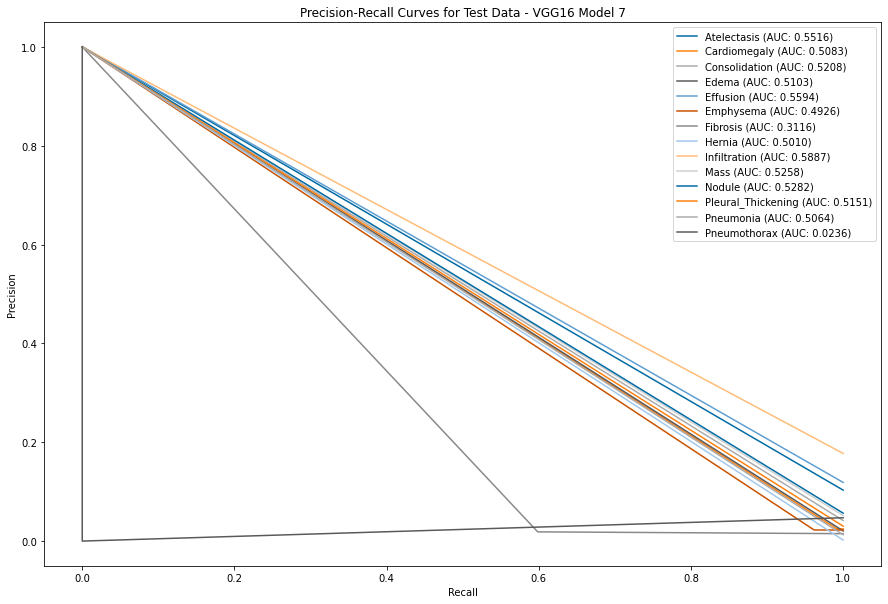

In [63]:
plot_precision_recall_auc(y_pred_7, test_df, labels, model_name='VGG16 Model 7')

### Model 8

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | None |
|Dataset | stratified_sampled_train_df |

In [64]:
train_generator_8, valid_generator_8, test_generator_8 = datagen_from_df(
    stratified_sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [65]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = True
    
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [66]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [67]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-8.h5'

chkpt_8 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [68]:
%%time
history_8 = model.fit(
    train_generator_8, 
    validation_data=valid_generator_8,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_8, early, reduce_lr]
)

Epoch 1/40


2022-01-24 20:13:17.830928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 17.2342

2022-01-24 20:20:18.045767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 21.02230, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-8.h5
282/282 [==============================] - 494s 2s/step - loss: 17.2342 - val_loss: 21.0223 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 17.2255
Epoch 00002: val_loss improved from 21.02230 to 21.01347, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-8.h5
282/282 [==============================] - 486s 2s/step - loss: 17.2255 - val_loss: 21.0135 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 17.2478
Epoch 00003: val_loss did not improve from 21.01347
282/282 [==============================] - 486s 2s/step - loss: 17.2478 - val_loss: 21.0147 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ETA: 0s - loss: 17.2565
Epoch 00004: val_loss improved from 21.01347 to 20.97542, saving model to /Users/tungng

In [69]:
y_pred_8 = model.predict(test_generator_8, batch_size=64, verbose=True)

2022-01-24 22:06:30.311241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 452s 1s/step


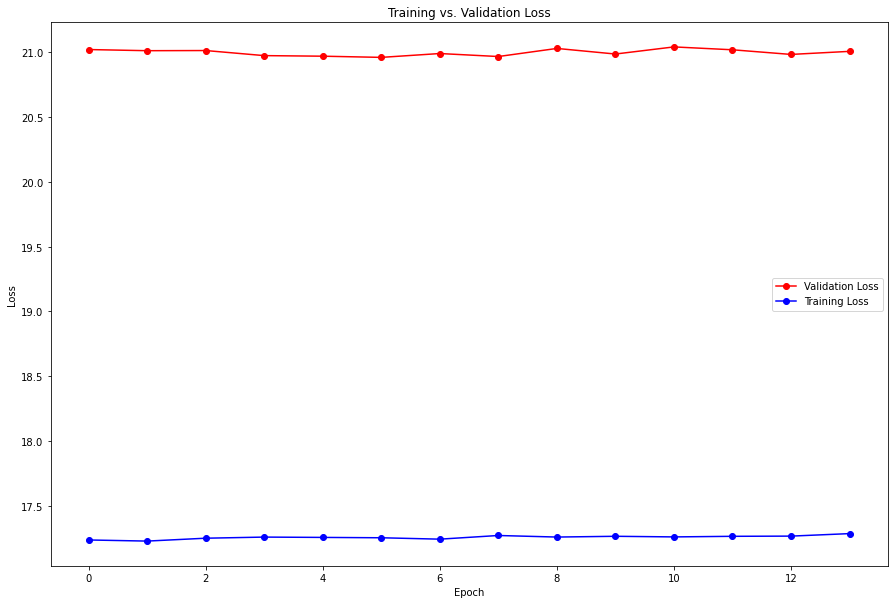

In [70]:
plot_losses(history_8)

AUC = 0.5000 for Atelectasis
AUC = 0.5014 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.5000 for Effusion
AUC = 0.4944 for Emphysema
AUC = 0.5278 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.5003 for Pneumothorax


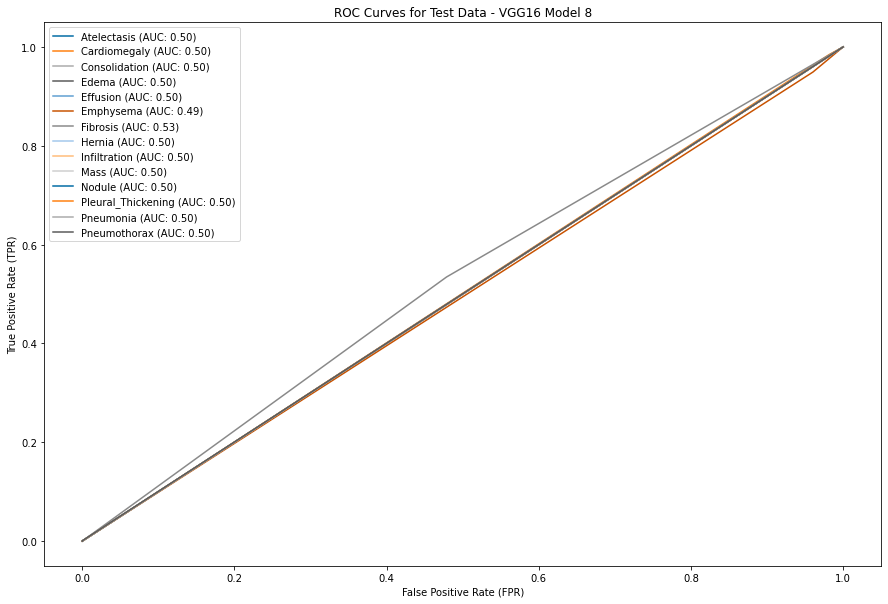

In [71]:
plot_roc_auc(y_pred_8, test_df, labels, model_name='VGG16 Model 8')

AUC = 0.5516 for Atelectasis
AUC = 0.5047 for Cardiomegaly
AUC = 0.0208 for Consolidation
AUC = 0.5103 for Edema
AUC = 0.5594 for Effusion
AUC = 0.4862 for Emphysema
AUC = 0.2791 for Fibrosis
AUC = 0.5010 for Hernia
AUC = 0.5887 for Infiltration
AUC = 0.5258 for Mass
AUC = 0.5282 for Nodule
AUC = 0.5151 for Pleural_Thickening
AUC = 0.5064 for Pneumonia
AUC = 0.1240 for Pneumothorax


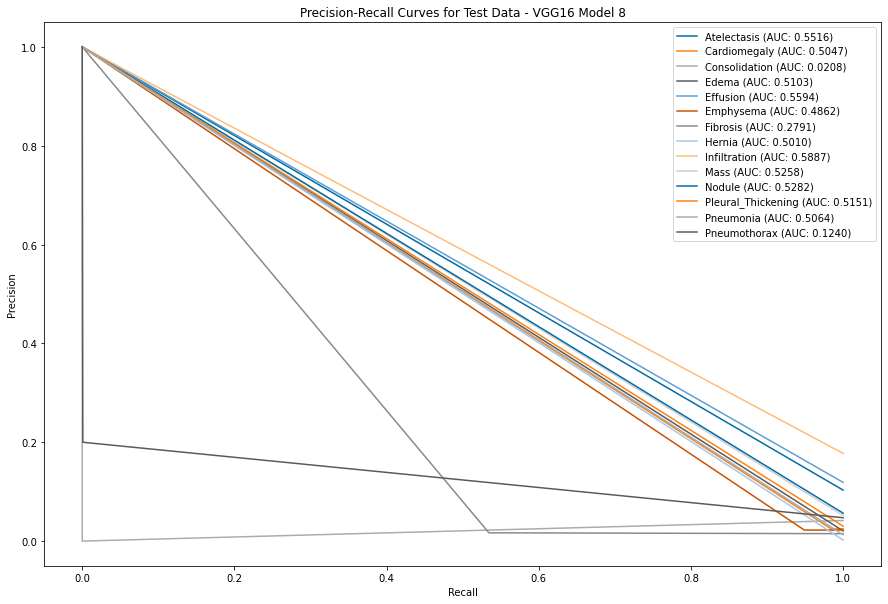

In [72]:
plot_precision_recall_auc(y_pred_8, test_df, labels, model_name='VGG16 Model 8')

### Model 9
Baseline Weighted Loss Model + GlobalAveragePooling

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | train_df |

In [73]:
train_generator_9, valid_generator_9, test_generator_9 = datagen_from_df(
    sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Found 28030 validated image filenames.


In [74]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(GlobalAveragePooling2D())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [75]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [76]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-9.h5'

chkpt_9 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [77]:
%%time
history_9 = model.fit(
    train_generator_9, 
    validation_data=valid_generator_9,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_9, early, reduce_lr]
)

Epoch 1/40


2022-01-24 22:14:05.169670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 19.5322

2022-01-24 22:18:26.696237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 36.12100, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-9.h5
250/250 [==============================] - 326s 1s/step - loss: 19.5322 - val_loss: 36.1210 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 19.5207
Epoch 00002: val_loss did not improve from 36.12100
250/250 [==============================] - 324s 1s/step - loss: 19.5207 - val_loss: 36.1212 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 19.5263
Epoch 00003: val_loss improved from 36.12100 to 36.10773, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-9.h5
250/250 [==============================] - 324s 1s/step - loss: 19.5263 - val_loss: 36.1077 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 19.5445
Epoch 00004: val_loss did not improve from 36.10773
250/250 [==========================

In [78]:
y_pred_9 = model.predict(test_generator_9, batch_size=64, verbose=True)

2022-01-24 23:14:10.839907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 452s 1s/step


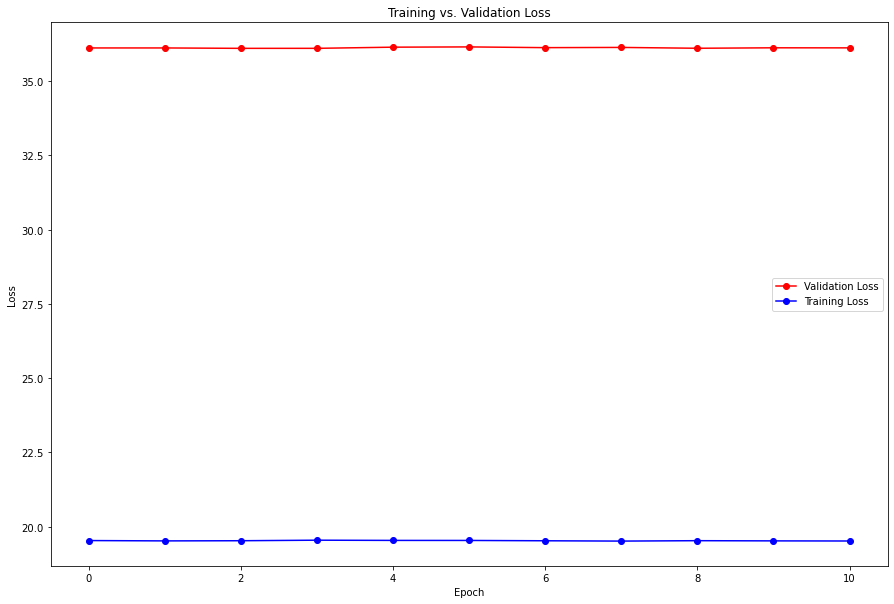

In [79]:
plot_losses(history_9)

AUC = 0.5000 for Atelectasis
AUC = 0.5000 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.5000 for Effusion
AUC = 0.5000 for Emphysema
AUC = 0.5000 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.4935 for Pneumothorax


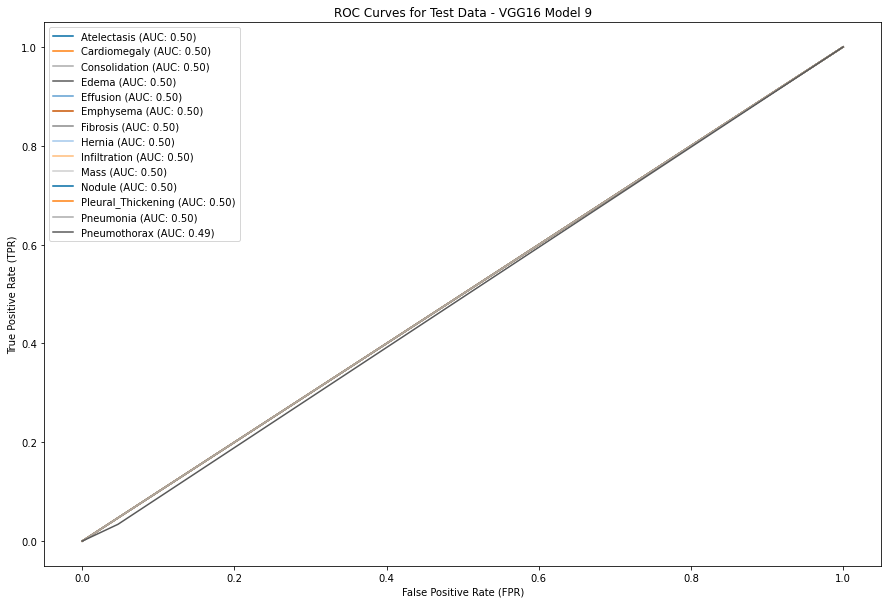

In [80]:
plot_roc_auc(y_pred_9, test_df, labels, model_name='VGG16 Model 9')

AUC = 0.5516 for Atelectasis
AUC = 0.5124 for Cardiomegaly
AUC = 0.5208 for Consolidation
AUC = 0.5103 for Edema
AUC = 0.5594 for Effusion
AUC = 0.5112 for Emphysema
AUC = 0.5075 for Fibrosis
AUC = 0.5010 for Hernia
AUC = 0.5887 for Infiltration
AUC = 0.5258 for Mass
AUC = 0.5282 for Nodule
AUC = 0.5151 for Pleural_Thickening
AUC = 0.5064 for Pneumonia
AUC = 0.0571 for Pneumothorax


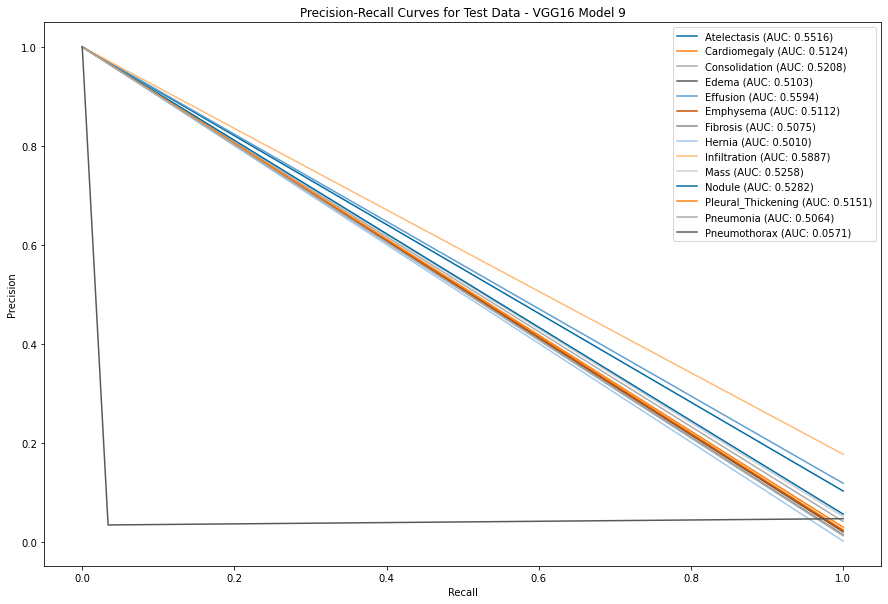

In [81]:
plot_precision_recall_auc(y_pred_9, test_df, labels, model_name='VGG16 Model 9')

### Model 10
Stratified Sampling + GlobalAveragePooling

|Parameter|Notes|
|:---|:---|
|Loss | Weighted Binary Cross-Entropy |
|Blocks Frozen | Block 1 - 3 |
|Dataset | stratified_sampled_train_df |

In [82]:
train_generator_10, valid_generator_10, test_generator_10 = datagen_from_df(
    stratified_sampled_train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    weight_col=None, sample_norm=False, rescale_factor=None
)

Found 18000 validated image filenames.
Found 4500 validated image filenames.
Found 28030 validated image filenames.


In [83]:
model = Sequential()

for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    if any(x in layer.name for x in ['block1', 'block2', 'block3']):
        layer.trainable = False
    
model.add(GlobalAveragePooling2D())
model.add(Dense(len(labels), activation='sigmoid'))
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)      

In [84]:
model.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [85]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-10.h5'

chkpt_10 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [86]:
%%time
history_10 = model.fit(
    train_generator_10, 
    validation_data=valid_generator_10,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_10, early, reduce_lr]
)

Epoch 1/40


2022-01-24 23:21:45.029298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


282/282 [==============================] - ETA: 0s - loss: 22.5320

2022-01-24 23:26:45.309562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 26.82831, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-10.h5
282/282 [==============================] - 373s 1s/step - loss: 22.5320 - val_loss: 26.8283 - lr: 0.0010
Epoch 2/40
282/282 [==============================] - ETA: 0s - loss: 22.5390
Epoch 00002: val_loss improved from 26.82831 to 26.81483, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-10.h5
282/282 [==============================] - 367s 1s/step - loss: 22.5390 - val_loss: 26.8148 - lr: 0.0010
Epoch 3/40
282/282 [==============================] - ETA: 0s - loss: 22.5248
Epoch 00003: val_loss improved from 26.81483 to 26.81293, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/VGG16_Trade_Studies/vgg16-model-10.h5
282/282 [==============================] - 368s 1s/step - loss: 22.5248 - val_loss: 26.8129 - lr: 0.0010
Epoch 4/40
282/282 [==============================] - ET

In [87]:
y_pred_10 = model.predict(test_generator_10, batch_size=64, verbose=True)

2022-01-25 00:54:08.493343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 454s 1s/step


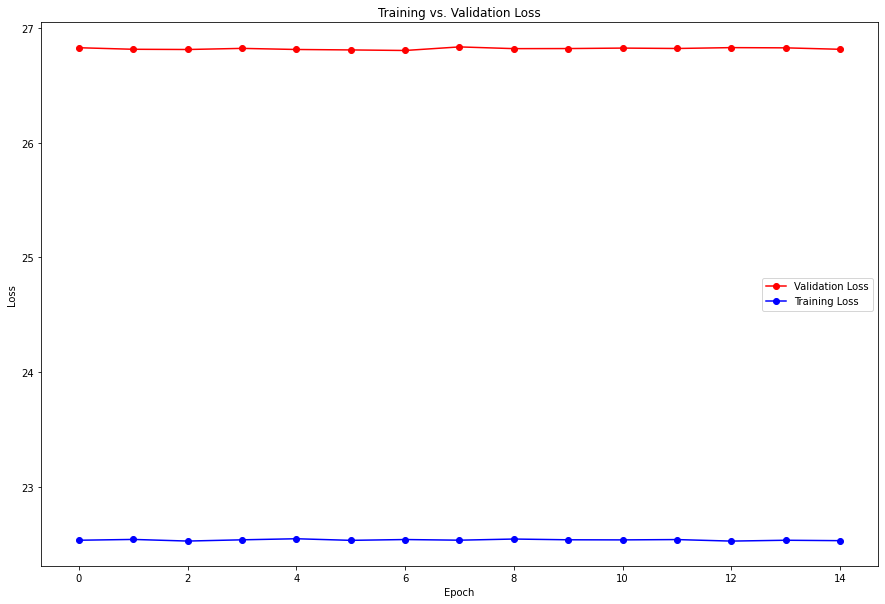

In [88]:
plot_losses(history_10)

AUC = 0.5000 for Atelectasis
AUC = 0.5000 for Cardiomegaly
AUC = 0.5000 for Consolidation
AUC = 0.5000 for Edema
AUC = 0.5000 for Effusion
AUC = 0.5000 for Emphysema
AUC = 0.5000 for Fibrosis
AUC = 0.5000 for Hernia
AUC = 0.5000 for Infiltration
AUC = 0.5000 for Mass
AUC = 0.5000 for Nodule
AUC = 0.5000 for Pleural_Thickening
AUC = 0.5000 for Pneumonia
AUC = 0.4926 for Pneumothorax


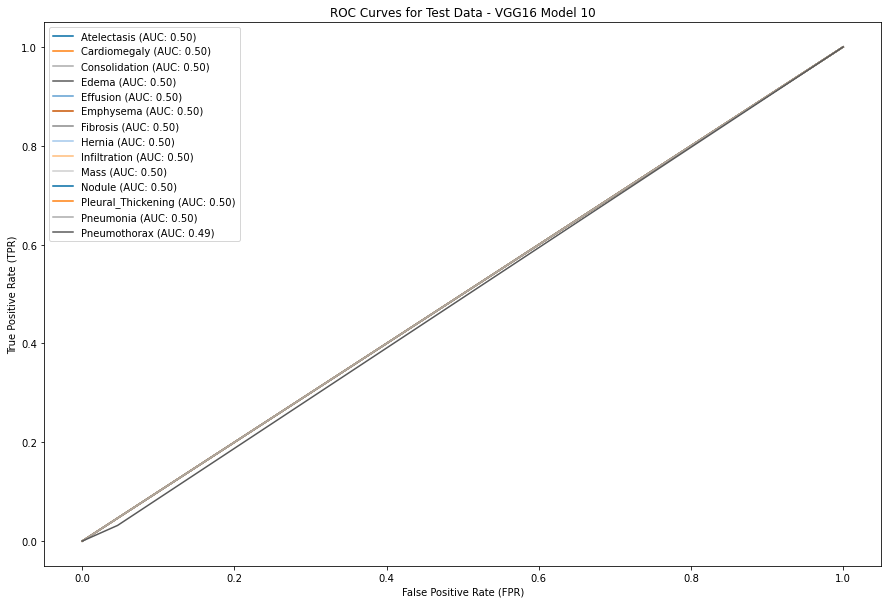

In [89]:
plot_roc_auc(y_pred_10, test_df, labels, model_name='VGG16 Model 10')

AUC = 0.5516 for Atelectasis
AUC = 0.5124 for Cardiomegaly
AUC = 0.5208 for Consolidation
AUC = 0.5103 for Edema
AUC = 0.5594 for Effusion
AUC = 0.5112 for Emphysema
AUC = 0.5075 for Fibrosis
AUC = 0.5010 for Hernia
AUC = 0.5887 for Infiltration
AUC = 0.5258 for Mass
AUC = 0.5282 for Nodule
AUC = 0.5151 for Pleural_Thickening
AUC = 0.5064 for Pneumonia
AUC = 0.0551 for Pneumothorax


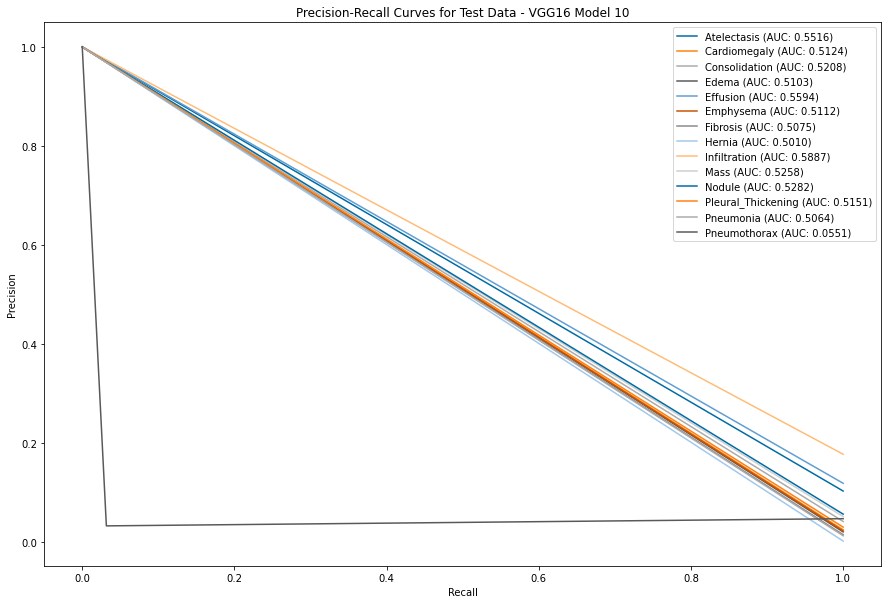

In [90]:
plot_precision_recall_auc(y_pred_10, test_df, labels, model_name='VGG16 Model 10')

## Store Variables
---